# Import Libraries

In [ ]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from IPython.display import clear_output
from matplotlib.pyplot import imshow
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.metrics import *
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import backend as k
import datetime


# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random

In [ ]:
os.listdir('/content/drive/MyDrive/Dataset_Classroom')

['Writing On Board',
 'Argue',
 'Hand Raise',
 'Eating In Class',
 'Sitting On Desk',
 'Holding Book',
 'Holding Mobile',
 'Writing On Textbook',
 'Reading Book',
 'Explainig The Subject']

In [ ]:
# Abnormal 'Writing On Board',
# Abnormal 'Argue',
# Normal 'Hand Raise',
# Abnormal 'Eating In Class',
# Abnormal 'Sitting On Desk',
# Abnormal 'Holding Book',
# Abnormal 'Holding Mobile',
# Normal 'Writing On Textbook',
# Normal 'Reading Book',
# Normal 'Explainig The Subject'


In [ ]:
lst = ['Writing On Board',
 'Argue',
 'Hand Raise',
 'Eating In Class',
 'Sitting On Desk',
 'Holding Book',
 'Holding Mobile',
 'Writing On Textbook',
 'Reading Book',
 'Explainig The Subject']


In [ ]:
abnorm=['Writing On Board',
 'Argue',
 'Eating In Class',
 'Sitting On Desk',
 'Holding Book',
 'Holding Mobile',]
norm= [
 'Hand Raise',
 'Writing On Textbook',
 'Reading Book',
 'Explainig The Subject']


## Data Labels

In [ ]:
abnormel=[]
normal=[]
for l in abnorm:
    abn = os.listdir('/content/drive/MyDrive/Dataset_Classroom/'+l)
    abnormel = abnormel + ['/content/drive/MyDrive/Dataset_Classroom/'+l+'/'+ab for ab in abn]
for l in norm:
    abn = os.listdir('/content/drive/MyDrive/Dataset_Classroom/'+l)
    normal = normal + ['/content/drive/MyDrive/Dataset_Classroom/'+l+'/'+ab for ab in abn]


In [ ]:
df = pd.DataFrame()
df['path'] = normal
df['class'] = 1
df2 = pd.DataFrame()
df2['path'] = abnormel
df2['class'] = 0

df = df.append(df2)
train_df = df

In [ ]:
train_df

,path,class
0,/content/drive/MyDrive/Dataset_Classroom/Hand ...,1
1,/content/drive/MyDrive/Dataset_Classroom/Hand ...,1
2,/content/drive/MyDrive/Dataset_Classroom/Hand ...,1
3,/content/drive/MyDrive/Dataset_Classroom/Hand ...,1
4,/content/drive/MyDrive/Dataset_Classroom/Hand ...,1
...,...,...
55,/content/drive/MyDrive/Dataset_Classroom/Holdi...,0
56,/content/drive/MyDrive/Dataset_Classroom/Holdi...,0
57,/content/drive/MyDrive/Dataset_Classroom/Holdi...,0
58,/content/drive/MyDrive/Dataset_Classroom/Holdi...,0


## Define Labels and Videos Split

In [ ]:
content = []
i = 0
n = 40
while len(content) < 10 and i < 102:
    if len(train_df[train_df['class']==i]) >= n:
        df_temp = train_df[train_df['class']==i].iloc[:n]
        path = df_temp['path']
        content.append(path)
        
    i += 1
    

content = np.array(content)

In [ ]:
content = content.reshape(80,)
y = np.array([i//40 for i in range(0,80)])

# Defining Function and Data Splitting

In [ ]:
def read_frames(root_folder,arr,each_nth=10):
    videos=[]
    for j  in range(len(arr)):
        clear_output()
        print(np.round(80*j/len(arr),3))
            
        vcap=cv2.VideoCapture(root_folder+arr[j])
        success=True
  
        frames=[]
        cnt=0
        while success:
            try:
                success,image=vcap.read()
                cnt+=1
                if cnt%each_nth==0:
                    image=resize(image,(128,192))
                    frames.append(image)
            except Exception as e:
                print(e)
        videos.append(frames)
    return videos

In [ ]:
def select_frames(frames_arr , n=10):
    videos=[]
    for i in range(len(frames_arr)):
        frames=[]
        for t in np.linspace(0, len(frames_arr[i])-1, num=n):
            frames.append(frames_arr[i][int(t)])
        videos.append(frames)
        
    videos = np.array(videos)
    print(videos.shape)
    return videos

In [ ]:
X_frames = read_frames("",content)

79.0


In [ ]:
X_frames = select_frames(X_frames, 10)

(80, 10, 128, 192, 3)


In [ ]:
xtr, xte, ytr , yte = train_test_split(X_frames , y , shuffle=True,test_size = 0.2,random_state = 42)

# Analyzing Video Images

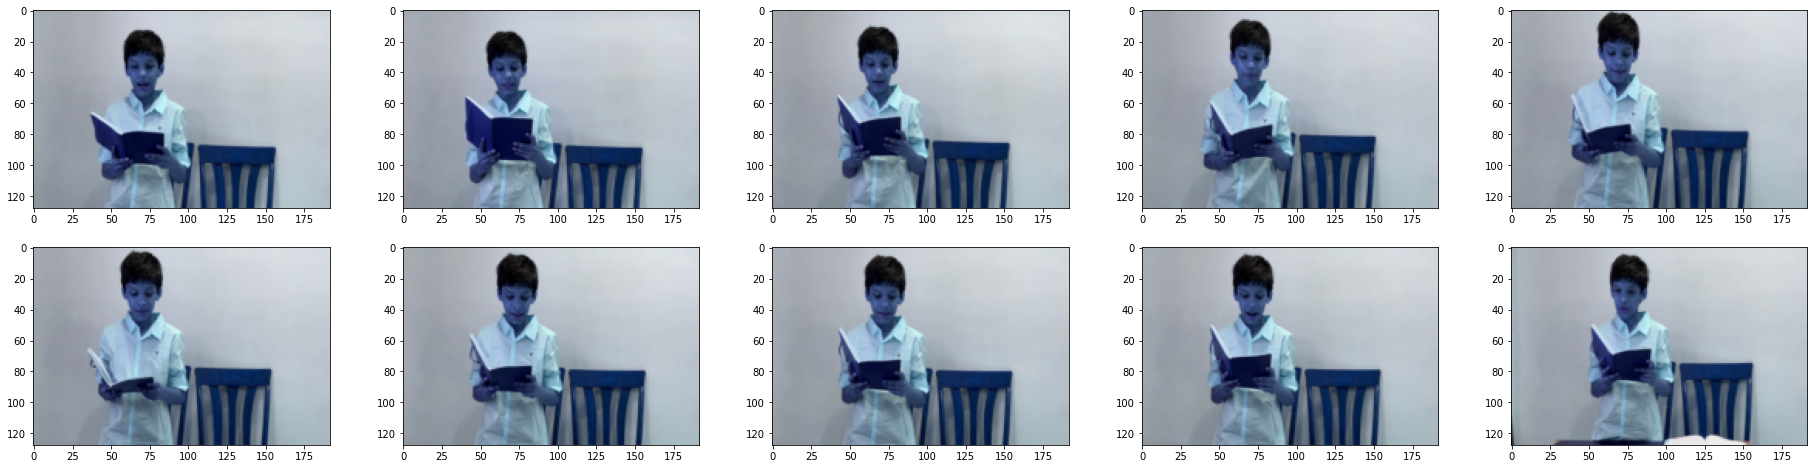

In [ ]:
fig = plt.figure(figsize=(32,8))

random_video_index = np.random.randint(0,len(X_frames))

for i,image in enumerate(X_frames[random_video_index]):
    ax = plt.subplot(2,5,i+1)
    imshow(image)

In [ ]:
def list_to_stack(xs):
    xs=tf.stack(xs, axis=1)
    s = tf.shape(xs)
    return xs

# Model Layers

In [ ]:
ish=(10, 128, 192, 3)
  
xs=[]


inp = Input(ish)

for slice_indx in range(0,10,1):
    x=Lambda(lambda x: x[:, slice_indx])(inp)
    x=BatchNormalization(momentum=0.8)(x)
    x=Conv2D(filters=20, kernel_size=3, padding='same', activation='relu')(x)
    x=BatchNormalization(momentum=0.8)(x)
    x=MaxPooling2D(pool_size=2)(x)

    x=Conv2D(filters=30, kernel_size=3, padding='same', activation='relu')(x)
    x=BatchNormalization(momentum=0.8)(x)
    x=MaxPooling2D(pool_size=2)(x)
    x=Conv2D(filters=30, kernel_size=3, padding='same', activation='relu')(x)

    xs.append(x)
    

t=Lambda(list_to_stack)(xs)
t=Conv3D(50,3,padding='same')(t)
t=BatchNormalization(momentum=0.8)(t)
target_shape=(10,32*48*50)
t=Reshape(target_shape)(t)
t=GRU(25, return_sequences=True)(t)
t=GRU(50, return_sequences=False,dropout=0.5)(t)

t=Dense(100,'relu')(t)
t=Dense(10,'relu')(t)
out=Dense(1, activation='sigmoid')(t)

model = Model(inputs=inp, outputs=out)
opt = tf.keras.optimizers.SGD(lr=0.0087)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 128, 19  0           []                               
                                2, 3)]                                                            
                                                                                                  
 lambda (Lambda)                (None, 128, 192, 3)  0           ['input_1[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 128, 192, 3)  0           ['input_1[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 128, 192, 3)  0           ['input_1[0][0]']            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


 batch_normalization_19 (BatchN  (None, 128, 192, 20  80         ['conv2d_18[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 batch_normalization_22 (BatchN  (None, 128, 192, 20  80         ['conv2d_21[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 batch_normalization_25 (BatchN  (None, 128, 192, 20  80         ['conv2d_24[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 batch_normalization_28 (BatchN  (None, 128, 192, 20  80         ['conv2d_27[0][0]']              
 ormalizat

In [ ]:
history = model.fit(xtr, ytr, epochs=30, batch_size=10,validation_data=(xte, yte),shuffle  = True)

Epoch 1/30
7/7 [==============================] - 30s 3s/step - loss: 0.6884 - accuracy: 0.5000 - val_loss: 0.6986 - val_accuracy: 0.3750
Epoch 2/30
7/7 [==============================] - 22s 3s/step - loss: 0.6467 - accuracy: 0.7031 - val_loss: 0.6645 - val_accuracy: 0.8750
Epoch 3/30
7/7 [==============================] - 20s 3s/step - loss: 0.5921 - accuracy: 0.8906 - val_loss: 0.6152 - val_accuracy: 0.8750
Epoch 4/30
7/7 [==============================] - 20s 3s/step - loss: 0.5510 - accuracy: 0.9688 - val_loss: 0.5946 - val_accuracy: 0.8125
Epoch 5/30
7/7 [==============================] - 21s 3s/step - loss: 0.5170 - accuracy: 0.9844 - val_loss: 0.5713 - val_accuracy: 0.8125
Epoch 6/30
7/7 [==============================] - 21s 3s/step - loss: 0.4700 - accuracy: 0.9844 - val_loss: 0.5554 - val_accuracy: 0.8125
Epoch 7/30
7/7 [==============================] - 21s 3s/step - loss: 0.4396 - accuracy: 1.0000 - val_loss: 0.5447 - val_accuracy: 0.8125
Epoch 8/30
7/7 [==================

In [ ]:
model.save("anomaly-detection.h5")


# Analyzing Model

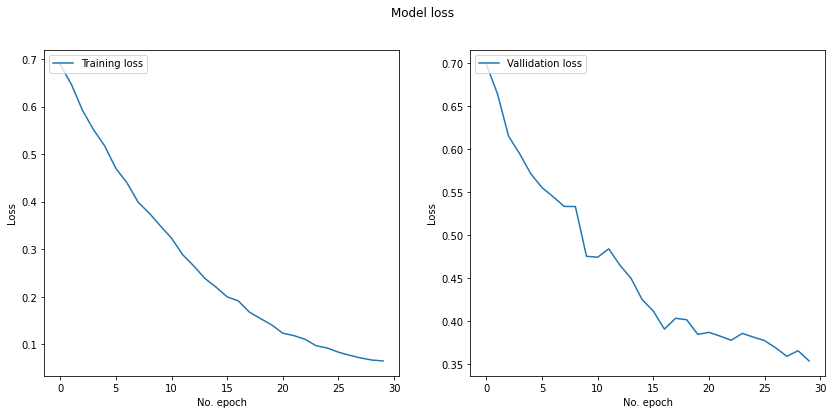

In [ ]:
fig = plt.figure(figsize=(14,6))

ax = plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training loss')
ax.legend(loc="upper left")
plt.ylabel('Loss')
plt.xlabel('No. epoch')
ax = plt.subplot(1,2,2)
plt.plot(history.history['val_loss'], label='Vallidation loss')
ax.legend(loc="upper left")
fig.suptitle('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.show()

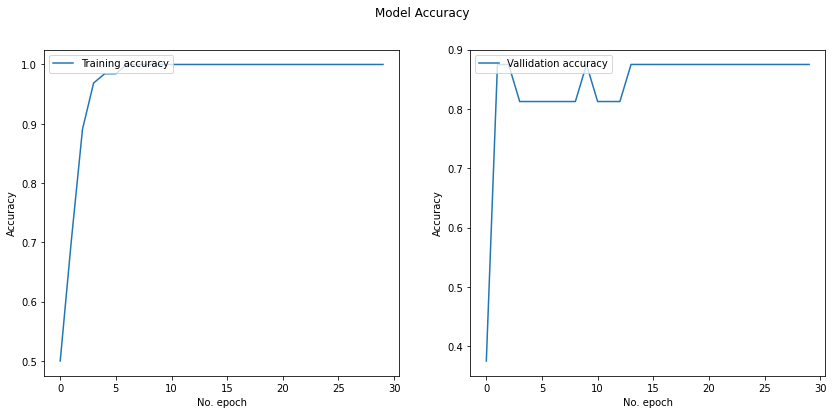

In [ ]:
fig = plt.figure(figsize=(14,6))

ax = plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training accuracy')
ax.legend(loc="upper left")
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
ax = plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'], label='Vallidation accuracy')
ax.legend(loc="upper left")
fig.suptitle('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.show()

# Model Predictions

In [ ]:
classes = []
for i in range(len(content)):
    class_name = content[i].split('/')[0]
    if class_name not in classes:
        classes.append(class_name)
        
num_classes = [i for i in range(2)]
class_map = dict(zip(num_classes,classes))

In [ ]:
random_videos = np.random.randint(0,len(xte),size=(10))
predicted  = model.predict(xte[random_videos],batch_size = 10)


In [ ]:
yte

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1])

In [ ]:
for x in range(0,len(xte)):
    predicted  = model.predict(xte[[x]],batch_size =2)
    if(predicted[0][0]>=0.5):  
        print('Normal')
    else:
        print('Abnormal')
        

Normal
Abnormal
Abnormal
Abnormal
Normal
Abnormal
Abnormal
Normal
Abnormal
Abnormal
Normal
Abnormal
Normal
Abnormal
Normal
Normal
